In [1]:
import pprint
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from skimage.io import imshow
from sklearn import metrics as mt
from matplotlib import pyplot as plt

from sklearn import datasets, metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, InputLayer

plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

keras.__version__

# You must download the data set from the following URL:
# https://www.cs.toronto.edu/~kriz/cifar.html

'2.12.0'

In [2]:
# tf.config.list_physical_devices('GPU')
print("Num of GPUs available: ", len(tf.test.gpu_device_name()))

Num of GPUs available:  13
Metal device set to: Apple M2

systemMemory: 24.00 GB
maxCacheSize: 8.00 GB



# Lab Assignment Six: Convolutional Network Architectures

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In this assignment, we will select a prediction task to perform on our dataset, evaluate a deep learning architecture and tune hyper-parameters.

**Dataset Selection**<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The dataset must be image data. We will multi-class classification.

## Preparation

#### **[1.5 points]** Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The dataset used is called cifar10 and it consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. Since the classes are evenly distributed among the dataset, we will use accuracy as the metric to evaluate the models' performances. The note above mentions that accuracy is rarely the best evaluation metric to use because it is a poor metric for datasets that have class imbalances, and that is how most of real world data is distributed.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For example, take a 2 class problem where there are 9,990 samples of Class 0, but only 10 samples of Class 1. If the model only predicts Class 0, it will have an accuracy of 99.9%. This number is misleading because it does not detect any Class 1 samples. In our case, the classes are balanced as mentioned previously, so accuracy is an appropriate measure for this dataset.<br/>

In [3]:
# Load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Print shapes of datasets
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')
print(f'Training Size: {X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]) * 100:.2f}%')
print(f'Testing Size: {X_test.shape[0] / (X_train.shape[0] + X_test.shape[0]) * 100:.2f}%')

# Print unique classes
print('Unique classes: ',end='')
print(np.unique(y_train))

NUM_CLASSES = len(np.unique(y_train))

X_train: (50000, 32, 32, 3)
y_train: (50000, 1)
X_test: (10000, 32, 32, 3)
y_test: (10000, 1)
Training Size: 83.33%
Testing Size: 16.67%
Unique classes: [0 1 2 3 4 5 6 7 8 9]


In [4]:
labels = {
    0: 'airplane',
    1:	'automobile',
    2:	'bird',
    3:	'cat',
    4:	'deer',
    5:	'dog',
    6:	'frog',
    7:	'horse',
    8:	'ship',
    9:	'truck'
}

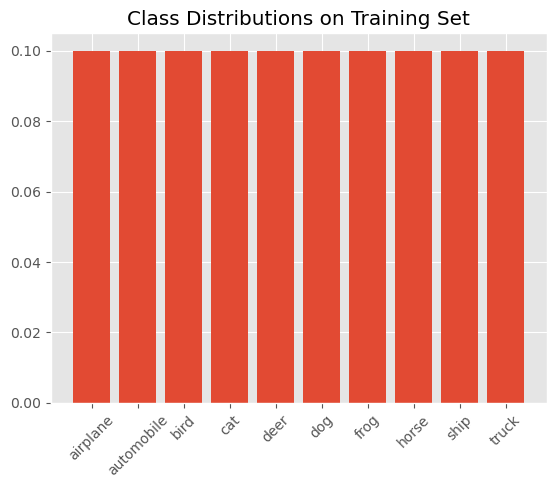

In [5]:
# Get the unique values and their counts
unique, counts = np.unique(y_train, return_counts=True)

# Calculate the proportions of each value
proportions = counts / len(y_train)

plt.bar(x=labels.values(), height=proportions)
plt.title('Class Distributions on Training Set')
plt.xticks(rotation=45)
plt.show()

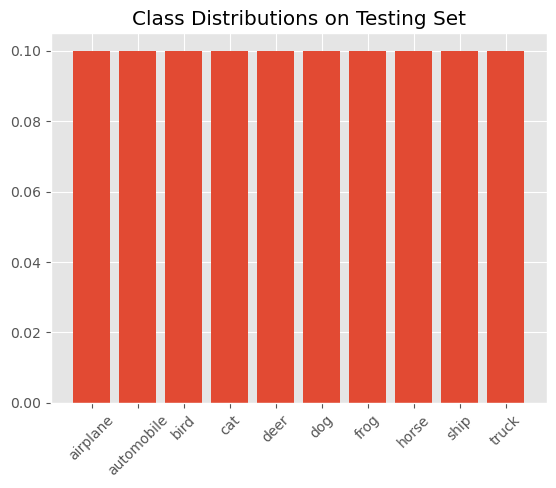

In [6]:
# Get the unique values and their counts
unique, counts = np.unique(y_test, return_counts=True)

# Calculate the proportions of each value
proportions = counts / len(y_test)

plt.bar(x=labels.values(), height=proportions)
plt.title('Class Distributions on Testing Set')
plt.xticks(rotation=45)
plt.show()

#### **[1.5 points]** Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;As mentioned in the previous section, cifar10 is already split into training and testing datasets with equal class distribution. Therefore, we will be using the given training and testing datasets as they solve the class imbalance problem and have a good distribution of the data, 84-17. Generally, the acceptable split is 80-20.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Furthermore, when comparing the different models, we will use a custom stratified 10-fold cross validation method. This means that the training dataset will be divided into 10 equal-sized stratified folds. Each fold has the same size as each other and they keep the same class distribution of the original training set, keeping our accuracy measure effective. After each fold has been created, the model is trained on 1 of them and tested on the other 9. This process is repeated 10 times so that each fold is used both for training and testing at different times. We will then compare each model's average performance and choose the best model and the best hyperparameters. That model will be tested on the testing dataset to evaluate its real efficiency. Note: During the cross-validation, the models will not have access to the final testing set.

In [24]:
# FIXME - lower values to test
args = {'epochs': 1, 'shuffle': True, 'verbose': 1}

In [8]:
# Create custom k-fold cross-validation and helper functions

# Simple Evaluation method based on accuracy
def simple_eval(model, train_X, train_y, test_X, test_y,model_args=None, verbose=0, data_gen=None):
    mets = {}
    if verbose == 1:
        print("=====================",model_args)
    
    # Fits model on train data
    if data_gen is None:
        history = model.fit(train_X,train_y,**model_args)
    else:
        # Data Generation is here
        history = model.fit_generator(data_gen.flow(train_X, train_y),
            **model_args)
    
    # Checks accuracy on test data
    yhat = np.argmax(model.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    mets['accuracy'] = acc
    
    return model,mets

# Create basic model if user doesn't provide one
def basic_model():
    cnn3 = Sequential()

    num_filt_layers = [32, 32]
    for num_filters in num_filt_layers:
        cnn3.add( Conv2D(filters=num_filters, 
                        kernel_size=(3,3), 
                        padding='same',
                        input_shape=(32,32,3)
                        ) )
        cnn3.add( Activation('relu'))
        cnn3.add( MaxPooling2D(pool_size=(2, 2)) )
        

    # add one layer on flattened output
    cnn3.add( Flatten() )
    cnn3.add( Dense(NUM_CLASSES) )
    cnn3.add( Activation('softmax') )

    # Let's train the model 
    cnn3.compile(loss='mean_squared_error',
                optimizer='rmsprop',
                metrics=['accuracy'])
    return cnn3

# Custom K Folding function
                            # create_model must be a function
def custom_k_folds(X, y, n_folds=10, create_model=basic_model, train_eval_model=simple_eval, model_args=None, verbose=0, datagen_=None):
    # Get stratified folds
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    
    # One-Hot Encode target
    y_ohe = keras.utils.to_categorical(y, NUM_CLASSES)

    print('X: ', X.shape)
    print('y: ', y_ohe.shape)
    
    # Run K times
    iterations = [] # Holds each fold's metrics
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        # Dictionary to hold metrics for this model
        val = {}
        # Progress tracker
        print("Running Fold", i+1, "/", n_folds)
        model = None # Clearing the NN.
        model = create_model() # Get clean model
        
        # Evaluate - Train (fit) model and get metrics
        model, mets, = train_eval_model(model, X[train_index], y_ohe[train_index], X[test_index], y_ohe[test_index],model_args=model_args,data_gen=datagen_)
        print(f'Accuracy for Fold {i+1}: {mets["accuracy"]}\n')

        # Append model and metrics to iterations list
        val['model'] = model
        val['metrics'] = mets
        iterations.append(val)

    # Each element in the list contains each iteration's model and metrics
    return iterations

In [9]:
# Function to plot a model's accuracies in each fold
def generate_bar(result, metric):
    plt.style.use("ggplot")
    
    # Get Fold numbers
    x_coord = [str(i+1) for i in range(len(result))]
    # Get values for each fold in the same order as x_coord
    y_val = [val['metrics'][metric] for val in result]

    # Plot bar graph
    plt.bar(x=x_coord, height=y_val)

    # Graph attributes
    plt.title(f'{np.average(y_val):0.2f} average {metric}')    
    plt.xlabel('Fold #')
    plt.ylabel(metric)
    plt.ylim(0.0, 1.0)
    
    plt.show()

In [10]:
%%time

# vals = custom_k_folds(X_train, y_train, model_args=args, n_folds=2)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [11]:
# generate_bar(vals,'accuracy')

## Modeling

#### **[1.5 points]**  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras ImageGenerator as a pre-processing step OR in the optimization loop. You can also use the Keras-cv augmenter (a separate package: https://keras.io/keras_cv/.)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Data expansion is a technique used for training machine learning models so that they can recognize images in different angles and rotations. It works by creating new images by applying a transformation, like flipping, rotating, scaling, or cropping, to the existing images in the dataset. Its main goal is to enhance the performance of the model by preventing overfitting. Furthermore, the technique must account for the missing pixels. By applying the transformation, the image might not fit exactly into its original shape. For example, rotate a squared image by 45 degrees. The image would have the shape of a diamond, and, therefore, would have empty spaces in the square frame). The data expansion technique must specify a way to fill those gaps. Some common ways to do it are nearest neighbor interpolation and linear interpolation.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Before choosing how we will expand our data, let's take a look at how some of the pictures look like.

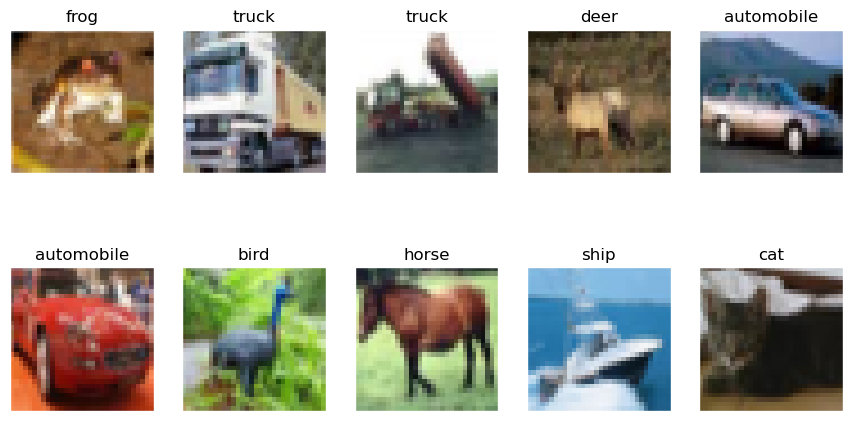

In [12]:
# Helper function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6,alt_labels=None):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].squeeze())
        plt.title(alt_labels[titles[i][0]], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, 32, 32,alt_labels=labels,n_col=5,n_row=2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Given the nature of our classes and domain knowledge, we will add some variations to our images, but nothing too crazy. We will flip them and rotate them slightly, but we will not be changing their color schemes or flipping them upside down as there is no need for such operations. Below are some examples of how the augmented pictures will look like. Unfortunately, due to the low quality, it is quite hard to see details of each transformation, but the rotations are still very clear in the images.

In [13]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest')
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)

# fits the model on batches with real-time data augmentation:
datagen.fit(X_train)

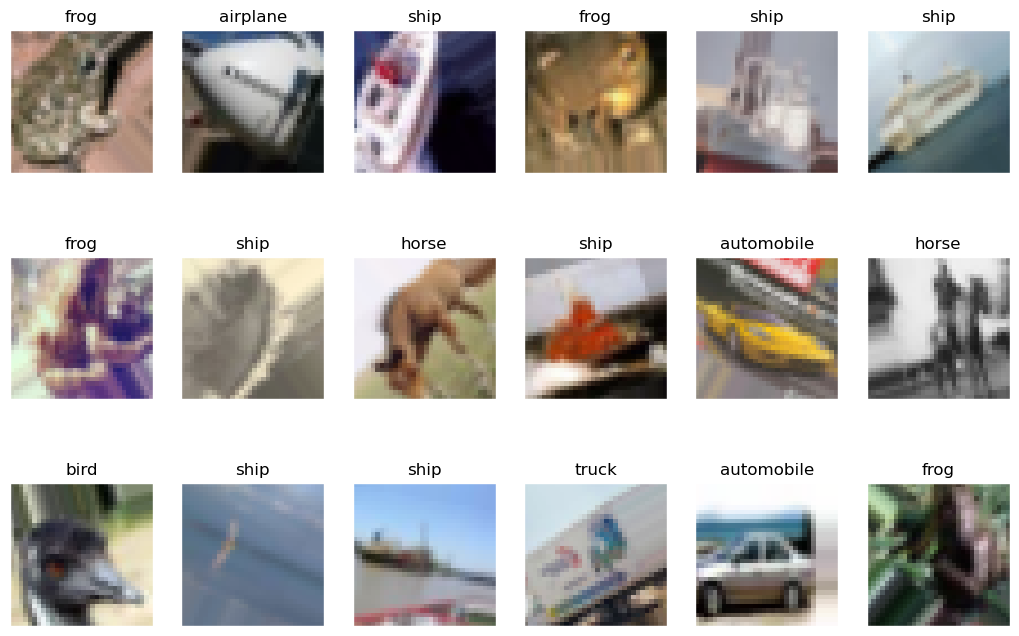

In [14]:
tmp_x = datagen.flow(X_train,y_train,batch_size=64,subset='training')


gen_data = tmp_x.next()

generated_labels = gen_data[1]
generated_imgs = gen_data[0]

generated_labels = np.array(generated_labels)


plot_gallery(generated_imgs/255.0,generated_labels,h=32,w=32,alt_labels=labels)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Before feeding the data to our models, we need to make sure that the data is scaled correctly. Each sample is has a dimension of 32x32x3. That means that each image is 32x32 pixels. Each datapoint represents a single pixel, and its value is stored by its RGB values. That is why all values are between 0-255. However, it is preferable for machine learning algorithms to work with normalized values. Thus, all values have been scaled to the range 0.0-1.0, inclusive.

In [15]:
print(f'Max Before Scale: {np.max(X_train.max())}')
print(f'Max Before Scale: {np.min(X_train.min())}')
print(f'Shape before Scale: {X_train.shape}')

X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

X_train = (X_train / 255.0)
X_test = (X_test / 255.0)

print(f'Max After Scale: {np.max(X_train.max())}')
print(f'Max Before Scale: {np.min(X_train.min())}')
print(f'Shape after Scale: {X_train.shape}')

Max Before Scale: 255
Max Before Scale: 0
Shape before Scale: (50000, 32, 32, 3)
Max After Scale: 1.0
Max Before Scale: 0.0
Shape after Scale: (50000, 32, 32, 3)


#### **[2 points]** Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture such as the number of filters--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

##### **Creating Models**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We have created 2 different convolutional network architectures. We also changed the number of filters and the stride values on both models at each convolution layer so that we have different variations to test the hyperparameter values.

In [16]:
def modelA_lower_param():
    cnn4 = Sequential()
    cnn4.add(Conv2D(50,(3,3), strides=1, padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D((2,2), strides=2,padding='same'))

    cnn4.add(Conv2D(25,(3,3), strides=1, padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(Dropout(0.2))
    cnn4.add(BatchNormalization())

    cnn4.add(MaxPooling2D((2,2),strides=1,padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D((2,2),strides=2,padding='same'))

    cnn4.add(Flatten())
    cnn4.add(Dense(units=512,activation='relu'))
    cnn4.add(Dense(units=NUM_CLASSES))
    cnn4.add(Activation('softmax'))
    cnn4.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return cnn4

In [17]:
def modelA_higher_param():
    cnn4 = Sequential()
    cnn4.add(Conv2D(75,(3,3), strides=2, padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D((2,2), strides=2,padding='same'))

    cnn4.add(Conv2D(50,(3,3), strides=2, padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(Dropout(0.2))
    cnn4.add(BatchNormalization())

    cnn4.add(MaxPooling2D((2,2),strides=1,padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D((2,2),strides=2,padding='same'))

    cnn4.add(Flatten())
    cnn4.add(Dense(units=512,activation='relu'))
    cnn4.add(Dense(units=NUM_CLASSES))
    cnn4.add(Activation('softmax'))
    cnn4.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return cnn4

In [18]:
def modelB_lower_param():
    mod = Sequential()
    mod.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
    mod.add(Activation('relu'))
    mod.add(BatchNormalization())
    mod.add(MaxPooling2D((3,3), strides=1, padding='same'))

    mod.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
    mod.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
    mod.add(Activation('relu'))
    mod.add(BatchNormalization())
    mod.add(MaxPooling2D((3,3), strides=2, padding='same'))

    mod.add(Conv2D(256, (3,3), strides=2, padding='same', activation='relu'))
    mod.add(Activation('relu'))
    mod.add(BatchNormalization())
    
    mod.add(Flatten())
    mod.add(Dense(units=512,activation='relu'))
    mod.add(Dense(units=NUM_CLASSES))
    mod.add(Activation('softmax'))
    mod.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return mod

In [19]:
def modelB_higher_param():
    mod = Sequential()
    mod.add(Conv2D(128, (3,3), strides=2, padding='same', activation='relu'))
    mod.add(Activation('relu'))
    mod.add(BatchNormalization())
    mod.add(MaxPooling2D((3,3), strides=2, padding='same'))

    mod.add(Conv2D(256, (3,3), strides=2, padding='same', activation='relu'))
    mod.add(Conv2D(256, (3,3), strides=1, padding='same', activation='relu'))
    mod.add(Activation('relu'))
    mod.add(BatchNormalization())
    mod.add(MaxPooling2D((3,3), strides=2, padding='same'))

    mod.add(Conv2D(512, (3,3), strides=4, padding='same', activation='relu'))
    mod.add(Activation('relu'))
    mod.add(BatchNormalization())
    
    mod.add(Flatten())
    mod.add(Dense(units=512,activation='relu'))
    mod.add(Dense(units=NUM_CLASSES))
    mod.add(Activation('softmax'))
    mod.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return mod

In [22]:
args

{'num_epochs': 1, 'shuffle_Val': True, 'verbo': 1}

2023-04-29 05:04:47.951212: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


196/196 [==============================] - 13s 58ms/step - loss: 1.5427 - accuracy: 0.4450


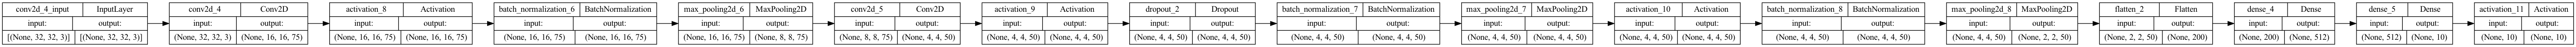

In [25]:
# Plotting architectures
y_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
first = modelA_higher_param()
first.fit(X_train,y_ohe,**args, batch_size=256)

modA = modelA_higher_param()
modA.fit(X_train,y_ohe,**args, batch_size=256)
plot_model(
    modA, to_file='Model A.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

196/196 [==============================] - 33s 158ms/step - loss: 1.3212 - accuracy: 0.5295


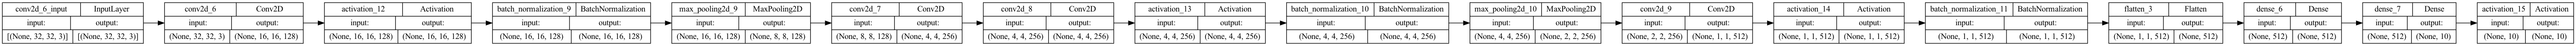

In [26]:
modB = modelB_higher_param()
modB.fit(X_train,y_ohe,**args, batch_size=256)
plot_model(
    modB, to_file='Model B.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

##### Visualizing Training and Validation Sets per Iteration

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;After creating the models, we must train and test them.

In [27]:
# One hot encoding the output values
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [28]:
# Helper Functions
def fit_gen(model_gen, X_train, y_train_ohe, X_test, y_test_ohe, steps=int(len(X_train)/128), num_epochs=1, verbo=1, shuffle_val=True):
    # Create a model using the user's model generator
    model_tmp = model_gen()
    # Fit the data and get the history from Keras
    history = model_tmp.fit_generator(datagen.flow(X_train, y_train_ohe), 
                  steps_per_epoch=steps, # how many generators to go through per epoch
                  epochs=num_epochs, verbose=verbo, shuffle=shuffle_val,
                  validation_data=(X_test,y_test_ohe)
                )
    return history

def plot_hist(history, title="Model Accuracy"):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Plot the training and validation loss values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [29]:
%%time
modelA_low = modelA_lower_param()

hist_A_low = fit_gen(modelA_lower_param, X_train, y_train_ohe, X_test, y_test_ohe, num_epochs=2)

Epoch 1/2
390/390 [==============================] - 21s 50ms/step - loss: 1.8960 - accuracy: 0.3370 - val_loss: 4.6803 - val_accuracy: 0.1070
Epoch 2/2
390/390 [==============================] - 18s 45ms/step - loss: 1.6184 - accuracy: 0.4118 - val_loss: 1.4297 - val_accuracy: 0.4847
CPU times: user 49.2 s, sys: 11.9 s, total: 1min 1s
Wall time: 39 s


In [30]:
%%time
modelA_high = modelA_higher_param()

hist_A_high = fit_gen(modelA_lower_param, X_train, y_train_ohe, X_test, y_test_ohe, num_epochs=2)

Epoch 1/2
390/390 [==============================] - 22s 52ms/step - loss: 1.8775 - accuracy: 0.3442 - val_loss: 5.1832 - val_accuracy: 0.1749
Epoch 2/2
390/390 [==============================] - 24s 62ms/step - loss: 1.6230 - accuracy: 0.4163 - val_loss: 1.3753 - val_accuracy: 0.5075
CPU times: user 54.9 s, sys: 12.5 s, total: 1min 7s
Wall time: 46.6 s


In [31]:
%%time
modelB_low = modelB_lower_param()

hist_B_low = fit_gen(modelA_lower_param, X_train, y_train_ohe, X_test, y_test_ohe, num_epochs=2)

Epoch 1/2
390/390 [==============================] - 23s 53ms/step - loss: 1.8957 - accuracy: 0.3363 - val_loss: 4.2896 - val_accuracy: 0.1562
Epoch 2/2
390/390 [==============================] - 19s 48ms/step - loss: 1.6166 - accuracy: 0.4111 - val_loss: 1.4111 - val_accuracy: 0.5049
CPU times: user 49.9 s, sys: 11.4 s, total: 1min 1s
Wall time: 41.4 s


In [32]:
%%time
modelB_high = modelB_higher_param()

hist_B_high = fit_gen(modelA_lower_param, X_train, y_train_ohe, X_test, y_test_ohe, num_epochs=2)

Epoch 1/2
390/390 [==============================] - 22s 51ms/step - loss: 1.9059 - accuracy: 0.3388 - val_loss: 4.8777 - val_accuracy: 0.1634
Epoch 2/2
390/390 [==============================] - 21s 54ms/step - loss: 1.6408 - accuracy: 0.4028 - val_loss: 1.4186 - val_accuracy: 0.4895
CPU times: user 51.4 s, sys: 11.6 s, total: 1min 2s
Wall time: 43 s


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The plots below show the performances of the training and validation sets per iteration of each model trained.

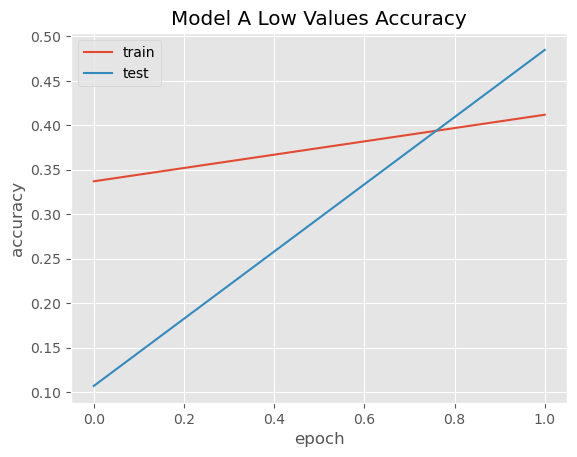

In [33]:
plot_hist(hist_A_low, 'Model A Low Values Accuracy')

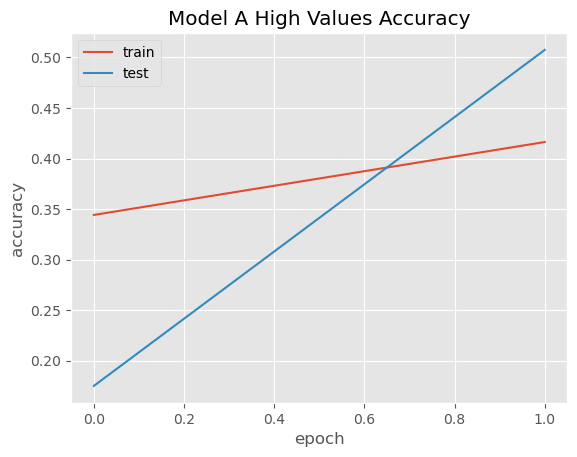

In [34]:
plot_hist(hist_A_high, 'Model A High Values Accuracy')

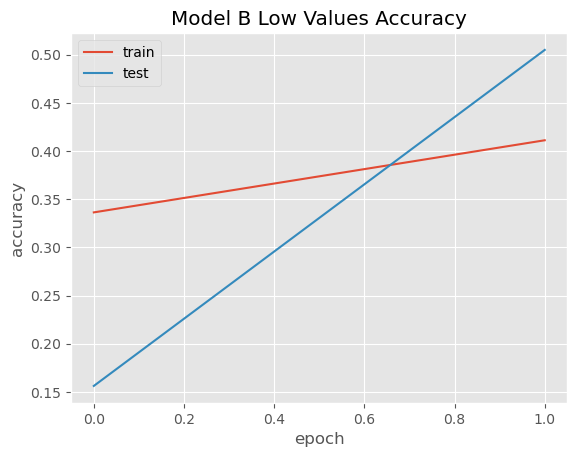

In [35]:
plot_hist(hist_B_low, 'Model B Low Values Accuracy')

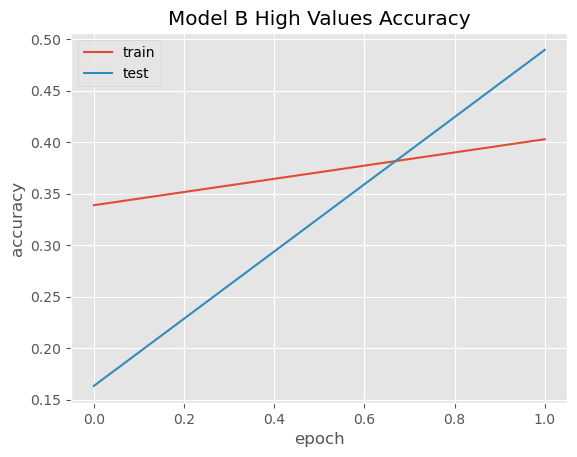

In [36]:
plot_hist(hist_B_high, 'Model B High Values Accuracy')

In [37]:
# # TESTING
# y_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)

# model_test = second_model()
# model_test.fit(X_train,y_ohe,**args, batch_size=128)

#### **[1.5 points]** Visualize the final results of the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models.

#### **[1 points]** Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

We will compare the performance of our best model, [BLANK], against a standard Multi-Layer Perceptron (MLP). 

In [38]:
%%time
# Create MLP
def MLP():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(64, activation='relu', input_dim=100))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

mlp = MLP()

# Train MLP
mlp.fit_generator(datagen.flow(X_train, y_train_ohe),
                  steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                  epochs=2, verbose=1, shuffle=True
                )

Epoch 1/2
390/390 [==============================] - 5s 11ms/step - loss: 0.3787 - accuracy: 0.8997
Epoch 2/2
390/390 [==============================] - 5s 12ms/step - loss: 0.3490 - accuracy: 0.9000
CPU times: user 16.4 s, sys: 2.46 s, total: 18.9 s
Wall time: 10.2 s


In [39]:
# Get predictions
y_hat_mlp = mlp.predict(X_test)
score_mlp = mlp.evaluate(X_test, y_test, verbose=0)

print("Test loss:", score_mlp[0])
print("Test accuracy:", score_mlp[1])
score_mlp

313/313 [==============================] - 1s 2ms/step
Test loss: 9.332208633422852
Test accuracy: 0.10000000149011612


[9.332208633422852, 0.10000000149011612]

In [40]:
# Do the same for the best model
best_model = modelA_higher_param()
best_model.fit_generator(datagen.flow(X_train, y_train_ohe),
                  steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                  epochs=2, verbose=1, shuffle=True
                )

Epoch 1/2
390/390 [==============================] - 19s 42ms/step - loss: 1.9052 - accuracy: 0.3070
Epoch 2/2
390/390 [==============================] - 15s 39ms/step - loss: 1.6961 - accuracy: 0.3818


In [41]:
# Get predictions
y_hat_best = best_model.predict(X_test)
# score_best = best_model.evaluate(X_test, y_test, verbose=0) DOESN'T work and idk why

# print("Test loss:", score_best[0])
# print("Test accuracy:", score_best[1])

313/313 [==============================] - 1s 3ms/step


In [ ]:
# FIXME: Missing ROC curve and AUC

## Exceptional Work

#### One idea (required for 7000 level students): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 